In [1]:
import pandas as pd
import requests
import numpy as np
from yahooquery import Ticker
import matplotlib.pyplot as plt

In [2]:
symbol = 'AAPL'
stock = Ticker(symbol)

In [47]:
#Get Historic FCF

df_cash = pd.DataFrame(stock.cash_flow())

df_cash['asOfDate'] = pd.to_datetime(df_cash['asOfDate'])
df_cash.set_index('asOfDate', inplace=True)
cash_period = df_cash['periodType'].iloc[0]
df_cash = df_cash.iloc[:, 2:]
df_cash['FreeCashFlow']

asOfDate
2020-09-30             NaN
2021-09-30    9.295300e+10
2022-09-30    1.114430e+11
2023-09-30    9.958400e+10
2024-09-30    1.088070e+11
2025-03-31    9.848600e+10
Name: FreeCashFlow, dtype: float64

In [4]:
#Get Historic Net Debt

df_balance = pd.DataFrame(stock.balance_sheet())
df_balance['asOfDate'] = pd.to_datetime(df_balance['asOfDate'])
df_balance.set_index('asOfDate', inplace=True)

df_balance = df_balance.iloc[:, 2:]

In [5]:
#Takes the last line in the table

net_debt = df_balance['NetDebt'].iloc[-1]
net_debt

76686000000.0

In [48]:
#Creating a custom function to convert a pandas column to a list

def column_to_list(df, column_name):
    data_list = df[column_name].tolist()
    data_list = [x for x in data_list if pd.notnull(x)]
    return data_list

In [7]:
historic_fcf = column_to_list(df_cash, 'FreeCashFlow')                      

In [8]:
#Calculate average growth rate of FCF for a basic forecast

fcf_avg_growth_rate = np.mean([
    (historic_fcf[i] - historic_fcf[i - 1]) / historic_fcf[i - 1]
    for i in range(1, len(historic_fcf))
])                     
                               

In [9]:
#Future estimates

future_year = 6
future_fcf = [historic_fcf[-1] * (1+fcf_avg_growth_rate) ** (i + 1) for i in range(future_year)]
future_fcf

[100708431105.98232,
 102981013502.71495,
 105304878902.2034,
 107681184554.62056,
 110111113824.60016,
 112595876780.53452]

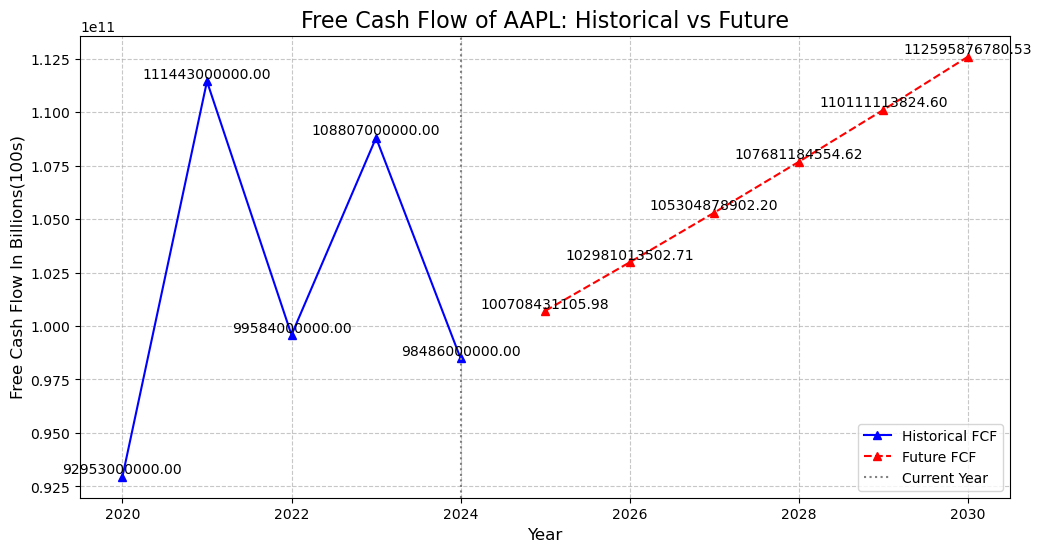

In [55]:
#Visualise 

#Sample data with our time constraint

historical_years = [2020, 2021, 2022, 2023, 2024]
future_years = [2025, 2026, 2027, 2028, 2029, 2030]

#Combine the data for graph 

total_years = historical_years + future_years
total_fcf = historic_fcf + future_fcf

#Construct plot
plt.figure(figsize=(12,6))

#Plotting the historical data
plt.plot(historical_years, historic_fcf, marker='^', linestyle='-', color='blue', label='Historical FCF')

#Plotting the future data
plt.plot(future_years, future_fcf, marker='^', linestyle='--', color='red', label='Future FCF')

#Vertical line to distinguish between the two lines
plt.axvline(x=historical_years[-1], color='grey', linestyle =':', label='Current Year')


#Adding visuals

plt.title(f'Free Cash Flow of {symbol}: Historical vs Future', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Free Cash Flow In Billions(100s)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

#Adding data labels
for i, value in enumerate(total_fcf):
    plt.text(total_years[i], value, f'{value:.2f}', ha='center', va='bottom')

#Showing the plot

plt.show()



In [11]:
#Get number of outstanding shares from Companiesmarketsharecap.com

import requests 
from bs4 import BeautifulSoup

company = 'apple'

url = f'https://companiesmarketcap.com/apple/shares-outstanding/'
response = requests.get(url)

#Parse HTML

soup = BeautifulSoup(response.content, 'html.parser')

shares_outstanding_element = soup.find('span', class_='background-ya')
shares_outstanding = shares_outstanding_element.text.strip() if shares_outstanding_element else 'Not Found'
shares_standing

'14,994,082,000'

In [12]:
#Number of outstanding is returned as a string not a numeric
#If the integer conversion fails, it tries to convert the string to a float after removing commas.


def string_to_number(s):
    try:
        return int(s.replace(',',''))
    except ValueError:
        try:
            return float(s.replace(',',''))
        except ValueError:
            print(f"Error: Unable  to convert {s} to a number.")
            return None
shares_outstanding_num = string_to_number(shares_outstanding)
shares_outstanding_num

14994082000

In [14]:
#Pull WACC - #403 error pulled therefore for now until doing a manual wacc formula ill take the 9.0 [WACC 19/06] off the website to complete the DCF.



url = f'https://valueinvesting.io/AAPL/valuation/wacc'
response = requests.get(url)

#Parse HTML

soup = BeautifulSoup(response.content, 'html.parser')


wacc_element = soup.find('td', class_='align_right orange')
wacc = wacc_element.text.strip() if wacc_element else 'Not Found'
response



<Response [403]>

In [16]:
# (1) Calculating PV using PV formula

def present_value(fcf, wacc):
    return [fcf[i]/(1 + wacc)**(i +1) for i in range(len(fcf))]
pv = present_value(fcf = future_fcf, wacc = 0.09)
pv


[92393056060.53423,
 86677058751.54865,
 81314687858.11235,
 76284065895.85742,
 71564668854.87727,
 67137242465.55088]

In [35]:

def DCF(fcf, wacc, terminal_growth_rate, net_debt, shares_outstanding_num):
    
    pv_fcf = present_value(fcf,wacc)

    # (2) Terminal Value Growth rate assuming perpetuity (constant rate (in industry = 3%)), Terminal Value is the PV of all FFCF beyond the forecasted period.
    # NOTE TO SELF - want most recent fcf so index [-1]

    terminal_value = (fcf[-1] * (1 + terminal_growth_rate))/(wacc-terminal_growth_rate)

    # (3) Discount terminal value to present

    pv_terminal_value = terminal_value/(1+wacc) **len(fcf)

    # (4) Calculate enterprise value
    # NOTE: sum up future fcf and the terminal value

    enterprise_value = sum(pv_fcf) +  pv_terminal_value 

    # (5) Calculate Equity Value 
    
    equity_value = enterprise_value - net_debt

    # (6) Calculate Intrinsic value of stock

    intrinsic_stock_price = equity_value/shares_outstanding_num

    return print(f'Intrinsic Stock Price: ${intrinsic_stock_price:.2f}')

In [36]:
DCF (fcf=future_fcf, wacc=0.09, terminal_growth_rate=0.03, net_debt=net_debt, shares_outstanding_num=shares_outstanding_num)

Intrinsic Stock Price: $103.45


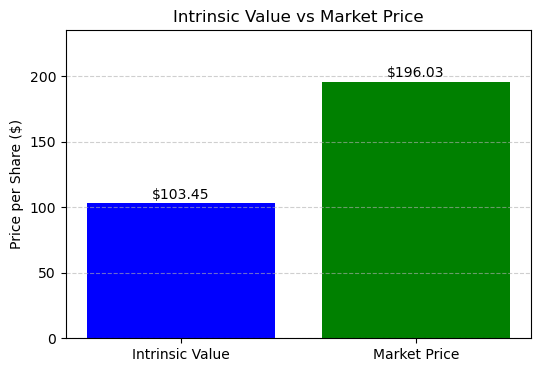

In [45]:
import matplotlib.pyplot as plt

intrinsic_value = 103.45
market_price = 196.03

labels = ['Intrinsic Value', 'Market Price']
values = [intrinsic_value, market_price]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=['blue', 'green'])
plt.ylabel("Price per Share ($)")
plt.title("Intrinsic Value vs Market Price")

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'${yval:.2f}', ha='center', va='bottom')

plt.ylim(0, max(values) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

